## Encoders

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU,Conv2D, BatchNormalization, Flatten, InputLayer, concatenate, ReLU
from tensorflow.keras.layers import Conv2DTranspose,Input,Dense,Reshape, Activation, Flatten, Concatenate
from tensorflow.keras.models import Sequential

In [2]:
def conv_block(filters, kernel_size=3, strides=2, padding = 'same'):
    x = Sequential([Conv2D(filters,kernel_size=kernel_size, strides=strides,padding= padding),
    BatchNormalization(),
    ReLU()])
    return x
def deconv_block(filters, kernel_size=3, strides=2, padding = 'same'):
    x = Sequential([Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding=padding),
    BatchNormalization(),
    ReLU()])
    return x
class UNetModel(tf.keras.Model):
  def __init__(self,filters,encoded_features, dense_layer=False):
    super().__init__()
    self.dense_layer = dense_layer
    self.conv1 = conv_block(filters,kernel_size=3, strides=2,padding= 'same')
    self.conv2 = conv_block(2*filters,kernel_size=3, strides=2,padding= 'same')
    self.conv3 = conv_block(4*filters,kernel_size=3, strides=2,padding= 'same')
    self.conv4 = conv_block(8*filters,kernel_size=3, strides=2,padding= 'same')
    self.conv5 = conv_block(8*filters,kernel_size=3, strides=1,padding= 'same')
    self.deconv1 = deconv_block(8*filters,kernel_size=3, strides=2,padding= 'same')
    self.deconv2 = deconv_block(4*filters,kernel_size=3, strides=2,padding= 'same')
    self.deconv3 = deconv_block(2*filters,kernel_size=3, strides=2,padding= 'same')
    self.deconv4 = deconv_block(filters,kernel_size=3, strides=2,padding= 'same')
    self.deconv5 = deconv_block(3,kernel_size=3, strides=1,padding= 'same')
    self.dense_edncoder = Dense(encoded_features, activation = 'relu')
    self.dense_decoder = Dense(4*256, activation = 'relu')
    self.reshape = Reshape((2,2,256))
  def encode(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x) 
    x = Flatten()(x)
    if self.dense_layer:
      x = self.dense_edncoder(x)
    return x
  

  def call(self,x):
    conv_block1 = self.conv1(x)
    conv_block2 = self.conv2(conv_block1)
    conv_block3 = self.conv3(conv_block2)
    conv_block4 = self.conv4(conv_block3)
    d = self.conv5(conv_block4)
    if self.dense_layer:
      d = Flatten()(d)
      d = self.dense_edncoder(d)
      d = self.dense_decoder(d)
      d = self.reshape(d)
    deconv_block1 = self.deconv1(d)
    merge1 = Concatenate()([deconv_block1, conv_block3])
    deconv_block2 = self.deconv2(merge1)
    merge2 = Concatenate()([deconv_block2, conv_block2])
    deconv_block3 = self.deconv3(merge2)
    merge3 = Concatenate()([deconv_block3, conv_block1])
    deconv_block4 = self.deconv4(merge3)

    final_deconv = self.deconv5(deconv_block4)

    dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
    return dae_outputs
  pass



def build_encoder(encoded_dimension):
    model = Sequential([

    Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(encoded_dimension, activation='relu')
    ])
    return model
def build_decoder():
    model = Sequential([
    Dense(16 * 16 * 256, activation='relu'),
    Reshape((16, 16, 256)),

    Conv2DTranspose(filters=256, kernel_size=3,strides=1, padding='valid'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=256, kernel_size=3, strides=1, padding='valid'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=128, kernel_size=3,strides=1, padding='valid'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='valid'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=64, kernel_size=3,strides=1, padding='valid'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='valid'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=32, kernel_size=3,strides=1, padding='valid'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=3, kernel_size=3,strides=1, padding='valid'),
    Activation('sigmoid')
    ])
    return model
class SimpleDAE(tf.keras.Model):
    def __init__(self,encoded_dimension):
        super().__init__()


        self.encoder = build_encoder(encoded_dimension)
        self.decoder = build_decoder()
    def call(self,x):
        x = self.encoder(x)
        return self.decoder(x)

## Random Noise

In [3]:
import numpy as np
import cv2
from skimage.util import random_noise
from scipy.fft import dctn, idctn

def normal_noise(x):
    return random_noise(x, mode='gaussian', clip=True)


def s_and_p_noise(x):
    return random_noise(x, mode='s&p', clip=True)


def poisson_noise(image):
    noisy = random_noise(image, mode="poisson", clip=True)
    return noisy


def apply_noise(image: np.array, noise: str):
    if noise == 'poisson':
        return poisson_noise(image)
    elif noise == 'normal':
        return normal_noise(image)


def apply_random_noise(image):
    return apply_noise(image, np.random.choice(['poisson', 'normal']))

## Encoders Training

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.datasets import cifar100, cifar10
from tensorflow.python.keras.callbacks import ModelCheckpoint, History


(train_data_clean, _), (test_data_clean, _) = cifar100.load_data()
train_data_clean = train_data_clean.astype('float32')/255.
train_data_noisy = np.zeros(train_data_clean.shape)
for i in range(train_data_clean.shape[0]):
    train_data_noisy[i] =  normal_noise(train_data_clean[i])
test_data_noisy = np.zeros(test_data_clean.shape)
for i in range(test_data_clean.shape[0]):
    test_data_noisy[i] =  normal_noise(test_data_clean[i])

### Simple U- Net autoencoder

In [5]:
import datetime
import tensorflow as tf
import os
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

modelU = UNetModel(32,256)
modelU.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(clipnorm=1), metrics=['accuracy'])
encoded = modelU.encode(train_data_clean[:10])

In [6]:
Unet_history = modelU.fit(train_data_noisy,train_data_clean, batch_size=64,verbose=1, epochs=40, validation_split=0.15, callbacks=[ callback])


Epoch 1/40
665/665 [==============================] - 31s 42ms/step - loss: 0.0421 - accuracy: 0.6090 - val_loss: 0.0402 - val_accuracy: 0.6819
Epoch 2/40
665/665 [==============================] - 27s 41ms/step - loss: 0.0391 - accuracy: 0.6671 - val_loss: 0.0397 - val_accuracy: 0.6791
Epoch 3/40
665/665 [==============================] - 27s 41ms/step - loss: 0.0388 - accuracy: 0.6746 - val_loss: 0.0396 - val_accuracy: 0.6975
Epoch 4/40
665/665 [==============================] - 27s 41ms/step - loss: 0.0390 - accuracy: 0.6785 - val_loss: 0.0397 - val_accuracy: 0.6980
Epoch 5/40
665/665 [==============================] - 27s 41ms/step - loss: 0.0387 - accuracy: 0.6812 - val_loss: 0.0395 - val_accuracy: 0.6830
Epoch 6/40
665/665 [==============================] - 27s 41ms/step - loss: 0.0388 - accuracy: 0.6841 - val_loss: 0.0395 - val_accuracy: 0.6682
Epoch 7/40
665/665 [==============================] - 27s 41ms/step - loss: 0.0387 - accuracy: 0.6855 - val_loss: 0.0396 - val_accuracy:

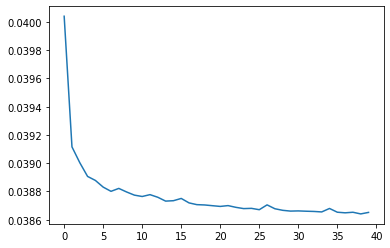

In [7]:
plt.plot(Unet_history.history['loss'])

In [8]:
modelUNoDense = UNetModel(32,256, True)
modelUNoDense.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(clipnorm=1), metrics=['accuracy'])

UneNoDenset_history = modelUNoDense.fit(train_data_noisy,train_data_clean, batch_size=64,verbose=1, epochs=40, validation_split=0.15, callbacks=[ callback])


Epoch 1/40
665/665 [==============================] - 32s 44ms/step - loss: 0.0424 - accuracy: 0.6042 - val_loss: 0.0398 - val_accuracy: 0.6672
Epoch 2/40
665/665 [==============================] - 29s 43ms/step - loss: 0.0391 - accuracy: 0.6704 - val_loss: 0.0406 - val_accuracy: 0.6831
Epoch 3/40
665/665 [==============================] - 29s 43ms/step - loss: 0.0395 - accuracy: 0.6765 - val_loss: 0.0397 - val_accuracy: 0.6707
Epoch 4/40
665/665 [==============================] - 29s 43ms/step - loss: 0.0390 - accuracy: 0.6803 - val_loss: 0.0396 - val_accuracy: 0.6988
Epoch 5/40
665/665 [==============================] - 29s 43ms/step - loss: 0.0391 - accuracy: 0.6800 - val_loss: 0.0396 - val_accuracy: 0.6955
Epoch 6/40
665/665 [==============================] - 29s 43ms/step - loss: 0.0392 - accuracy: 0.6869 - val_loss: 0.0396 - val_accuracy: 0.6996
Epoch 7/40
665/665 [==============================] - 29s 43ms/step - loss: 0.0389 - accuracy: 0.6851 - val_loss: 0.0397 - val_accuracy:

### U - net autoencoder with dense layer 

### Cusomized Simple Autoencoder

In [9]:

model = SimpleDAE(256*2*2)
model.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])

Simple_DEA_history = model.fit(train_data_noisy,train_data_clean, batch_size=64,verbose=1, epochs=40, validation_split=0.15,callbacks=[callback])



Epoch 1/40
665/665 [==============================] - 98s 143ms/step - loss: 0.0342 - accuracy: 0.4563 - val_loss: 0.0276 - val_accuracy: 0.5734
Epoch 2/40
665/665 [==============================] - 94s 141ms/step - loss: 0.0150 - accuracy: 0.6114 - val_loss: 0.0145 - val_accuracy: 0.6230
Epoch 3/40
665/665 [==============================] - 94s 141ms/step - loss: 0.0125 - accuracy: 0.6350 - val_loss: 0.0143 - val_accuracy: 0.6435
Epoch 4/40
665/665 [==============================] - 94s 141ms/step - loss: 0.0117 - accuracy: 0.6385 - val_loss: 0.0128 - val_accuracy: 0.6312
Epoch 5/40
665/665 [==============================] - 94s 141ms/step - loss: 0.0106 - accuracy: 0.6716 - val_loss: 0.0110 - val_accuracy: 0.6844
Epoch 6/40
665/665 [==============================] - 94s 141ms/step - loss: 0.0096 - accuracy: 0.6960 - val_loss: 0.0097 - val_accuracy: 0.6863
Epoch 7/40
665/665 [==============================] - 94s 141ms/step - loss: 0.0091 - accuracy: 0.7075 - val_loss: 0.0104 - val_ac

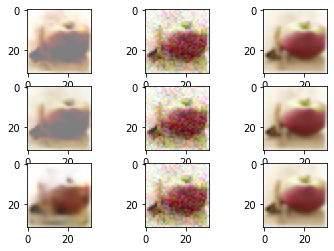

In [12]:
predU = modelU.predict(train_data_noisy[:10])
fig,ax = plt.subplots(3,3)
ax[0,0].imshow(predU[2])
ax[0,1].imshow(train_data_noisy[2])
ax[0,2].imshow(train_data_clean[2])


predUnodense = modelUNoDense.predict(train_data_noisy[:10])

ax[1,0].imshow(predUnodense[2])
ax[1,1].imshow(train_data_noisy[2])
ax[1,2].imshow(train_data_clean[2])

#%%

pred = model.predict(train_data_noisy[:10])

ax[2,0].imshow(pred[2])
ax[2,1].imshow(train_data_noisy[2])
ax[2,2].imshow(train_data_clean[2])

In [13]:
def build_encoder(encoded_dimension):
    model = Sequential([

    Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(encoded_dimension, activation='relu')
    ])
    return model
def build_decoder():
    model = Sequential([
    Dense(2 * 2 * 256, activation='relu'),
    Reshape((2, 2, 256)),

    Conv2DTranspose(filters=256, kernel_size=3,strides=1, padding='same'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=128, kernel_size=3,strides=2, padding='same'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=64, kernel_size=3,strides=2, padding='same'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=32, kernel_size=3,strides=2, padding='same'),
    ReLU(),
    BatchNormalization(),
    Conv2DTranspose(filters=3, kernel_size=3,strides=2, padding='same'),
    Activation('sigmoid')
    ])
    return model
class SimpleDAEpadd2(tf.keras.Model):
    def __init__(self,encoded_dimension):
        super().__init__()


        self.encoder = build_encoder(encoded_dimension)
        self.decoder = build_decoder()
    def call(self,x):
        x = self.encoder(x)
        return self.decoder(x)

In [15]:
modelpadd2 = SimpleDAEpadd2(256*2*2)
modelpadd2.compile(loss = 'mse', optimizer='adam', metrics=['accuracy'])


#%%

padd2_history = modelpadd2.fit(train_data_noisy,train_data_clean, batch_size=64,verbose=1, epochs=40, validation_split=0.15, callbacks=[callback])



Epoch 1/40
665/665 [==============================] - 18s 25ms/step - loss: 0.0324 - accuracy: 0.5281 - val_loss: 0.0232 - val_accuracy: 0.6070
Epoch 2/40
665/665 [==============================] - 16s 24ms/step - loss: 0.0169 - accuracy: 0.6233 - val_loss: 0.0166 - val_accuracy: 0.6424
Epoch 3/40
665/665 [==============================] - 16s 24ms/step - loss: 0.0149 - accuracy: 0.6398 - val_loss: 0.0154 - val_accuracy: 0.5753
Epoch 4/40
665/665 [==============================] - 16s 24ms/step - loss: 0.0136 - accuracy: 0.6588 - val_loss: 0.0133 - val_accuracy: 0.6929
Epoch 5/40
665/665 [==============================] - 16s 24ms/step - loss: 0.0124 - accuracy: 0.6975 - val_loss: 0.0122 - val_accuracy: 0.6792
Epoch 6/40
665/665 [==============================] - 16s 24ms/step - loss: 0.0116 - accuracy: 0.6998 - val_loss: 0.0115 - val_accuracy: 0.6978
Epoch 7/40
665/665 [==============================] - 16s 24ms/step - loss: 0.0111 - accuracy: 0.7053 - val_loss: 0.0109 - val_accuracy:

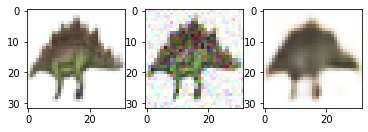

In [23]:
pred2padd = modelpadd2.predict(train_data_noisy[:10])
fig,ax = plt.subplots(1,3)
i = np.random.choice([x for x in range(10)])
ax[2].imshow(pred2padd[i])
ax[1].imshow(train_data_noisy[i])
ax[0].imshow(train_data_clean[i])

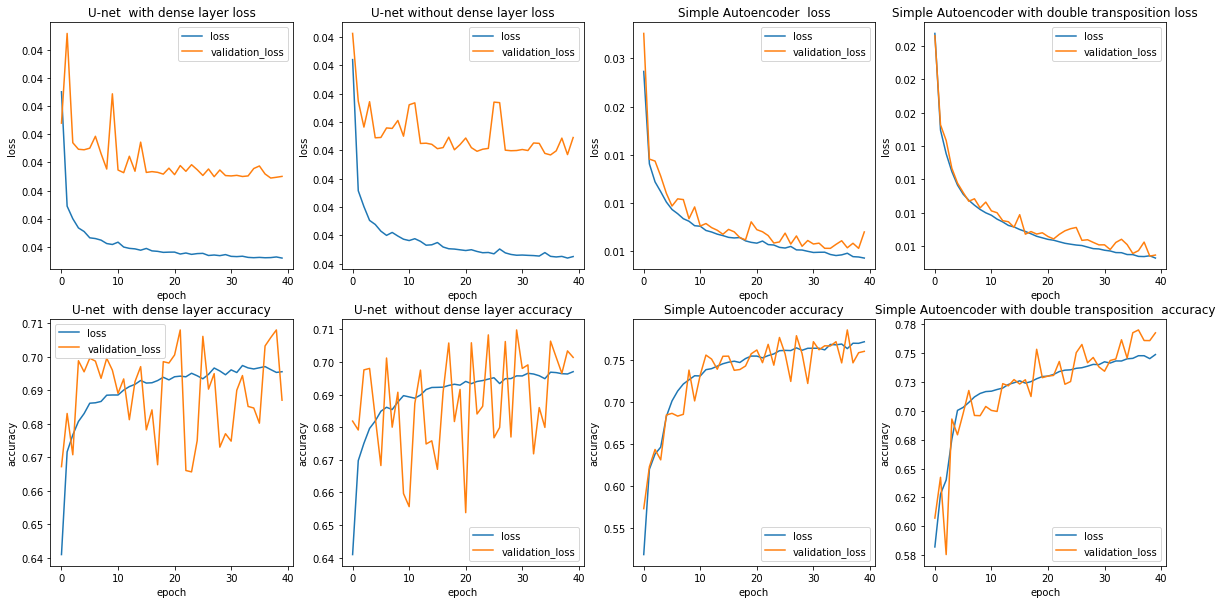

In [40]:
from matplotlib.ticker import FormatStrFormatter

fig,ax = plt.subplots(2,4,figsize = (20,10))
for i in range(2):
  for j in range(4):
    ax[i,j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[i,j].set_xlabel('epoch')
    ax[i,j].set_ylabel('loss') if i == 0 else ax[i,j].set_ylabel('accuracy')
ax[0,0].plot([i for i in range(40)],np.array([UneNoDenset_history.history['loss'], UneNoDenset_history.history['val_loss']]).T)
ax[0,0].set_title('U-net  with dense layer loss')
ax[0,0].legend(['loss','validation_loss'])
ax[0,1].plot([i for i in range(40)],np.array([Unet_history.history['loss'], Unet_history.history['val_loss']]).T)
ax[0,1].set_title('U-net without dense layer loss')
ax[0,1].legend(['loss','validation_loss'])
ax[0,2].plot([i for i in range(40)],np.array([Simple_DEA_history.history['loss'], Simple_DEA_history.history['val_loss']]).T)
ax[0,2].set_title('Simple Autoencoder  loss')
ax[0,2].legend(['loss','validation_loss'])
ax[0,3].plot([i for i in range(40)],np.array([padd2_history.history['loss'], padd2_history.history['val_loss']]).T)
ax[0,3].set_title('Simple Autoencoder with double transposition loss')
ax[0,3].legend(['loss','validation_loss'])
ax[1,0].plot([i for i in range(40)],np.array([UneNoDenset_history.history['accuracy'], UneNoDenset_history.history['val_accuracy']]).T)
ax[1,0].set_title('U-net  with dense layer accuracy')
ax[1,0].legend(['loss','validation_loss'])
ax[1,1].plot([i for i in range(40)],np.array([Unet_history.history['accuracy'], Unet_history.history['val_accuracy']]).T)
ax[1,1].set_title('U-net  without dense layer accuracy')
ax[1,1].legend(['loss','validation_loss'])
ax[1,2].plot([i for i in range(40)],np.array([Simple_DEA_history.history['accuracy'], Simple_DEA_history.history['val_accuracy']]).T)
ax[1,2].set_title('Simple Autoencoder accuracy')
ax[1,2].legend(['loss','validation_loss'])
ax[1,3].plot([i for i in range(40)],np.array([padd2_history.history['accuracy'], padd2_history.history['val_accuracy']]).T)
ax[1,3].set_title('Simple Autoencoder with double transposition  accuracy')
ax[1,3].legend(['loss','validation_loss'])
